# ELE2769 -  Remote Sensing Image Analysis - Assignment 1

## 1st Problem - Image Pan-Sharpening Correction

### Introduction

*Pan-Sharpening* is a technique used to create a single high resolution image by merging a panchromatic image of higher resolution with lower resolution multispectral bands. In this 1st problem, we'll create a pan-sharped image by using two different methods (PCA and HSV) and 3 different interpolation methods (bilinear, bicubic and nearest neighbour) and discuss its differences

### Notebook Setup:

In [1]:
%matplotlib notebook
import numpy as np #For numerical calculations
import matplotlib as mpl #For plotting and image import
import matplotlib.pyplot as plt 
import cv2 #For image interpolation and colorspace convertion
from sklearn.decomposition import PCA #For Principal Component Analysys
import pandas as pd #To be used in problem 2 for simple dataframes

In [2]:
save_figs = False
dpi = 300

### Function Definitions

For this problem we'll need 5 different functions:
* ***multichannel*** - Takes in 3 same-sized bands and puts them together to form a single multichannel image. It will be used both to create the RGB assembly as well as the NIR RG images.
* ***pansharpening_HSV*** - This function used the HSV method to pansharp the images. This method consists of converting the multichannel image to HSV, substituting the V value for the Pan and reconverting it to RGB.
* ***pansharpening_PCA*** - This function calculates the PCA of the multichannel image, takes in the PC1 and substitutes it by the adjusted Pan value (adjusted using the adjust_dist function)
* ***norm*** - This function normalized the input image in relation to the total range of the image $max(x) - min(x)$

In [3]:
def multichannel(chn1, chn2, chn3):
    '''This function takes in 3 same sized channels and puts them together in a single image'''
    
    if chn1.shape == chn2.shape == chn3.shape:
        im_out = np.zeros(chn1.shape + (3,))
        im_out[:,:,0] = chn1
        im_out[:,:,1] = chn2
        im_out[:,:,2] = chn3
        
        return im_out
    
    else:
        print('The Channels Must be The Same Size')

In [4]:
def pansharpening_HSV(im_in, im_pan):
    '''This function takes the RGB image, converts it to HSV and substitutes the V by the Pan band value of a same sized image'''
    
    if im_in.shape[:2] == im_pan.shape:
        im_in = im_in
        im_pan = im_pan
        img_HSV_in = cv2.cvtColor(im_in.astype('uint8'), cv2.COLOR_RGB2HSV)
        img_HSV_in[:,:,2] = im_pan
        img_HSV_out = cv2.cvtColor(img_HSV_in.astype('uint8'), cv2.COLOR_HSV2RGB)

        return img_HSV_out
    
    else:
        print('The X Y Sizes Should be the Same')

In [5]:
def pansharpening_PCA(im_in, im_pan, ms=True, report=False):
    '''This function takes the input image (RGB), executes a PCA analysis and substitutes the PC1 by the Pan band value of a same sized image. 
    The ms input=True will adjust the mean and standard deviation of the Pan data to that of the PC1.
    The report mode returns the PC1 and pan linear arrays'''

    
    
    if im_in.shape[:2] == im_pan.shape:
        new_shape = (im_in.shape[0]*im_in.shape[1],3)
        pan_newshape = im_pan.reshape(new_shape[0])
        
        
        pca = PCA(n_components=2)
        pcomponents = pca.fit_transform(im_in.reshape(new_shape))
        
        if ms == True:
            adjusted_pan = adjust_dist(pan_newshape, pcomponents[:,0])
        else:
            adjusted_pan = pan_newshape
        
        pcomponents[:,0] = adjusted_pan
        
        
        im_out = pca.inverse_transform(pcomponents)
        im_out = im_out.reshape(im_in.shape)
        
        if report == False:
            return im_out
        else:
            return pcomponents[:,0], pan_newshape
    
    else:
        print('The X Y Sizes Should be the Same')

In [6]:
def adjust_dist(in_dist, out_dist, report=False):
    '''This function takes in a distribution and adjusts its std and mean to that of the out distribution
    The report mode outputs the std and mean of the adjusted distribution'''
    adjusted_dist = np.float64(np.mean(out_dist) + (in_dist - np.mean(in_dist))*(np.std(out_dist)/np.std(in_dist)))
    
    if report==True:
        mean = np.mean(adjusted_dist)
        std = np.std(adjusted_dist)
        print("The mean is {}, the std is {}".format(mean, std))
        return adjusted_dist
    else:
        return adjusted_dist

In [7]:
def norm(im_in, scale=255):
    out_type = im_in
    im_out = np.zeros(im_in.shape)
    
    if len(im_in.shape) == 3:
        for i in range(im_in.shape[2]):
            chan_min = np.amin(im_in[:,:,i])
            chan_max = np.amax(im_in[:,:,i])
            im_out[:,:,i] = (im_in[:,:,i] - chan_min)/(chan_max-chan_min)
    
    if len(im_in.shape) == 2:
        chan_min = np.amin(im_in)
        chan_max = np.amax(im_in)
        im_out = (im_in - chan_min)/(chan_max-chan_min)
    
    return im_out*scale

### Loading the raw images

**As OpenCV and matplotlib deals with greyscale images differently (0-255 for openCV and 0-1 for mplt), all images read with mpl are multiplied by 255 to account for this difference and prevent any problems**

In [8]:
%%capture
cd Pan_Sharpening/

In [9]:
img_preffix = 'img_raw_'
img_raw = ['red', 'grn', 'blu', 'nir', 'pan']
for i in range(len(img_raw)):
    var = img_preffix + img_raw[i]
    vars()[var] = plt.imread('sjc_'+img_raw[i]+'.png')*255

### PAN vs Single bands

<IPython.core.display.Javascript object>


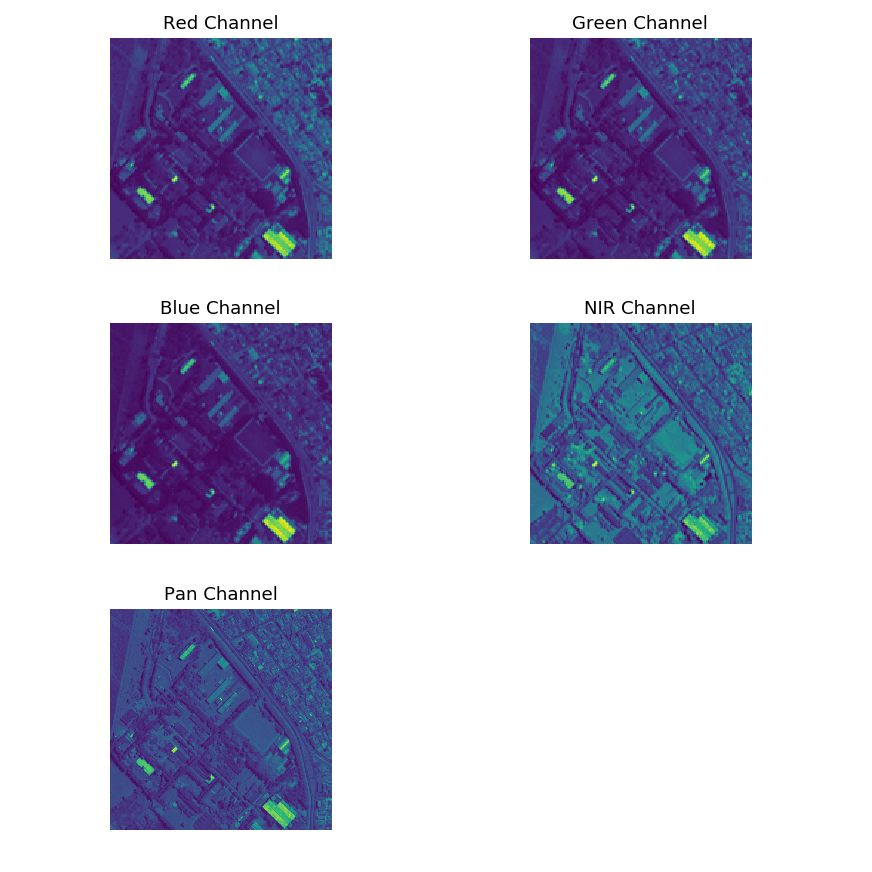

In [10]:
fig,((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
data = [img_raw_red, img_raw_grn, img_raw_blu, img_raw_nir, img_raw_pan]
titles = ['Red', 'Green', 'Blue', 'NIR', 'Pan']

for i in range(5):

    axes[i].imshow(data[i])
    axes[i].set_axis_off()
    axes[i].set_title(titles[i]+' Channel')
ax6.axis('off')
fig.tight_layout()


if save_figs == True:
    plt.savefig('raw_channels.png', dpi=dpi)

In the images above we can see clearly that the Panchromatic (Pan) channel has the highest resolution from the bands. The objective is then to use this high resolution image to enhance the multichannel image created by using the other bands 

### Comparing RGB with NIR RG

In [11]:
img_rgb = multichannel(img_raw_red,img_raw_grn,img_raw_blu)
img_nrg = multichannel(img_raw_nir,img_raw_red,img_raw_blu)

<IPython.core.display.Javascript object>


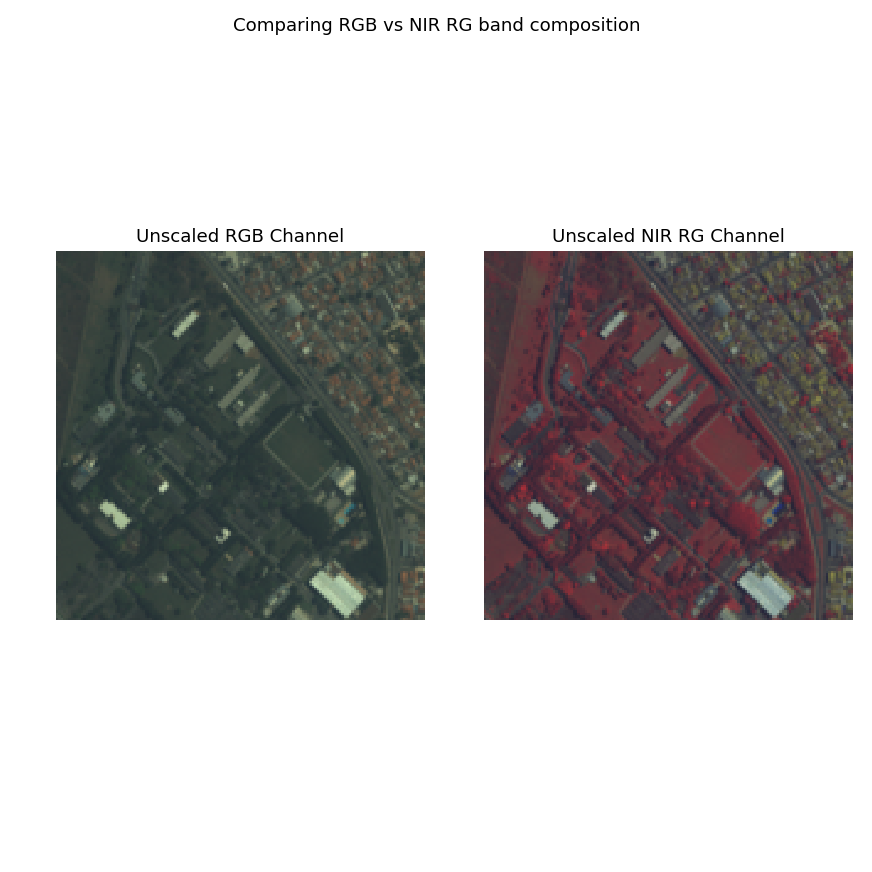

In [12]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (8,8))

axes = [ax1, ax2]
data = [img_rgb, img_nrg]
titles = ['RGB', 'NIR RG']

for i in range(2):

    axes[i].imshow(data[i].astype('uint8'))
    axes[i].set_axis_off()
    axes[i].set_title('Unscaled '+titles[i]+' Channel')

fig.tight_layout()
fig.suptitle('Comparing RGB vs NIR RG band composition')
if save_figs == True:
    plt.savefig('compose_channels.png', dpi=dpi)

In the images above we can see the bands combined to form a colored image. In the RGB image, the colors seem real, while in the NIR RG composition there is a red tint. This red tint seems to be most pronounced in the soil and vegetation, with the buildings maintaining similar RGB colors. This effect might be explained by the high reflectance that vegetation imposes on the NIR wavelenght

### The effect of image normalization

The original composed RGB images appeared to have a greenish tint to it, so we decided to analyse the effect of image normalization on the colors. The normalized image seems to have greater contrast with more realistic colors, specially in the roofs of buildings. In the end we decided not to normalize the images to prevent artificial effects as the color in some parts of the image seem to appear less realistic than others.
 
 $$ Normalized = \frac{x_i - min(x)}{max(x)-min(x)}$$

<IPython.core.display.Javascript object>


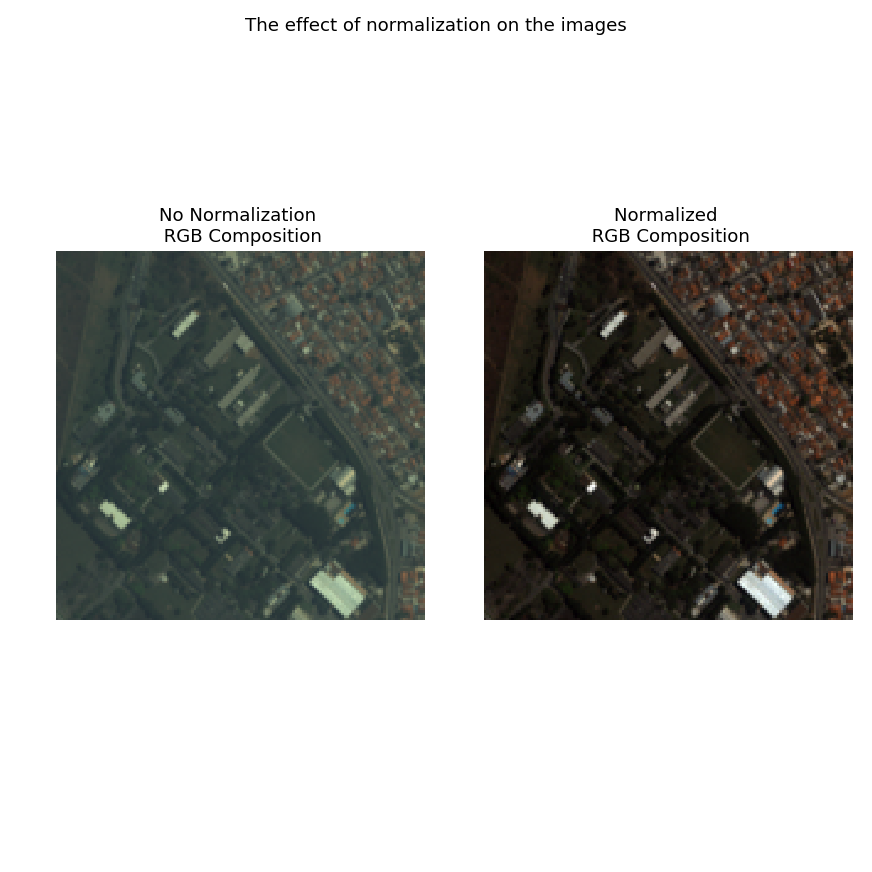

In [13]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (8,8))

ax1.imshow(img_rgb.astype('uint8'))
ax1.set_title('No Normalization \n RGB Composition')
ax1.set_axis_off()
ax2.imshow(norm(img_rgb).astype('uint8'))
ax2.set_title('Normalized \n RGB Composition')
ax2.set_axis_off()



fig.tight_layout()
fig.suptitle('The effect of normalization on the images')
if save_figs == True:
    plt.savefig('normalized_channels.png', dpi=dpi)

### Comparing different interpolation methods

To pan-sharp the images, it's first necessary to resize them. In this section the images were resize by using 3 different interpolation methods: Bilinear, Bicubic and Nearest Neighbour

In [14]:
img_rgb_resize_nn = cv2.resize((img_rgb),img_raw_pan.shape,interpolation = cv2.INTER_NEAREST)
img_rgb_resize_bl = cv2.resize((img_rgb),img_raw_pan.shape,interpolation = cv2.INTER_LINEAR)
img_rgb_resize_bc = cv2.resize((img_rgb),img_raw_pan.shape,interpolation = cv2.INTER_CUBIC)

In [15]:
img_nrg_resize_nn = cv2.resize((img_nrg),img_raw_pan.shape,interpolation = cv2.INTER_NEAREST)
img_nrg_resize_bl = cv2.resize((img_nrg),img_raw_pan.shape,interpolation = cv2.INTER_LINEAR)
img_nrg_resize_bc = cv2.resize((img_nrg),img_raw_pan.shape,interpolation = cv2.INTER_CUBIC)

<IPython.core.display.Javascript object>


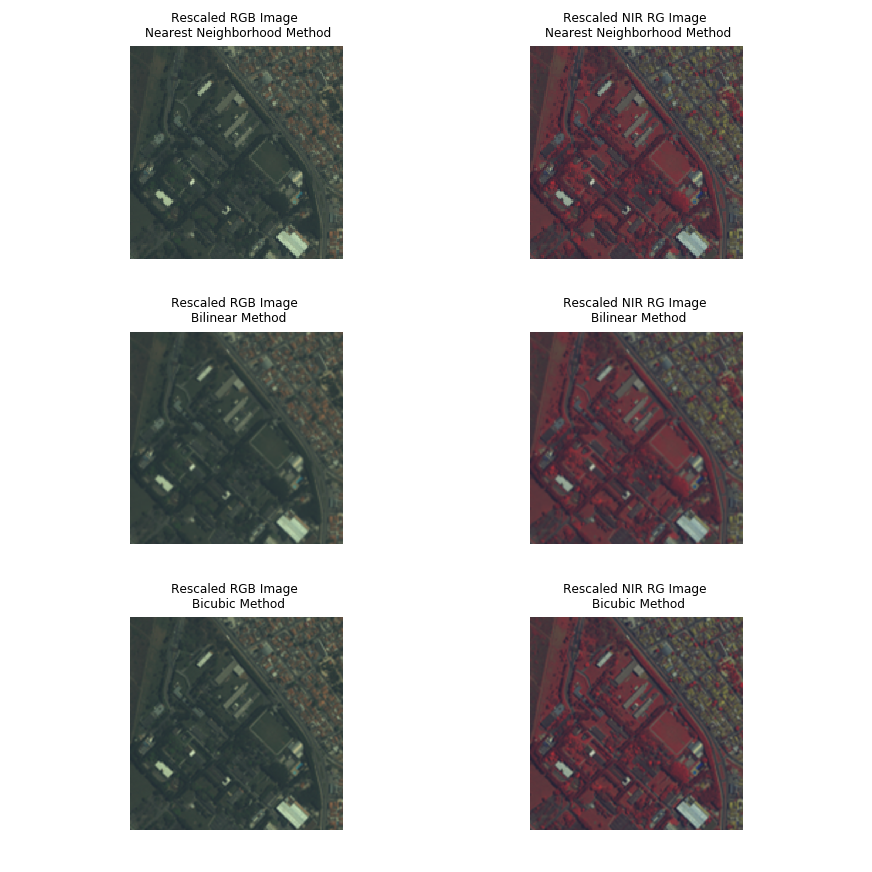

In [16]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_rgb_resize_nn.astype('uint8'))
ax1.set_axis_off()
ax1.set_title('Rescaled RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_rgb_resize_bl.astype('uint8'))
ax3.set_axis_off()
ax3.set_title('Rescaled RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_rgb_resize_bc.astype('uint8'))
ax5.set_axis_off()
ax5.set_title('Rescaled RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_nrg_resize_nn.astype('uint8'))
ax2.set_axis_off()
ax2.set_title('Rescaled NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_nrg_resize_bl.astype('uint8'))
ax4.set_axis_off()
ax4.set_title('Rescaled NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_nrg_resize_bc.astype('uint8'))
ax6.set_axis_off()
ax6.set_title('Rescaled NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()


if save_figs == True:
    plt.savefig('rescale.png', dpi=dpi)

By zooming in on the images we see that the nearest neighbour interpolation yields a pixelated image when compared with both the bilinear and bicubic methods. By comparing the bilinear to bicubic, it seems more blurred. By considering 16 pixels instead of 4, the bicubic method yields the better result. 

### Pan-Sharpening HSV

In [17]:
img_Pan_rgb_nn = pansharpening_HSV(img_rgb_resize_nn,img_raw_pan)
img_Pan_rgb_bl = pansharpening_HSV(img_rgb_resize_bl,img_raw_pan)
img_Pan_rgb_bc = pansharpening_HSV(img_rgb_resize_bc,img_raw_pan)

In [18]:
img_Pan_nrg_nn = pansharpening_HSV(img_nrg_resize_nn,img_raw_pan)
img_Pan_nrg_bl = pansharpening_HSV(img_nrg_resize_bl,img_raw_pan)
img_Pan_nrg_bc = pansharpening_HSV(img_nrg_resize_bc,img_raw_pan)

<IPython.core.display.Javascript object>


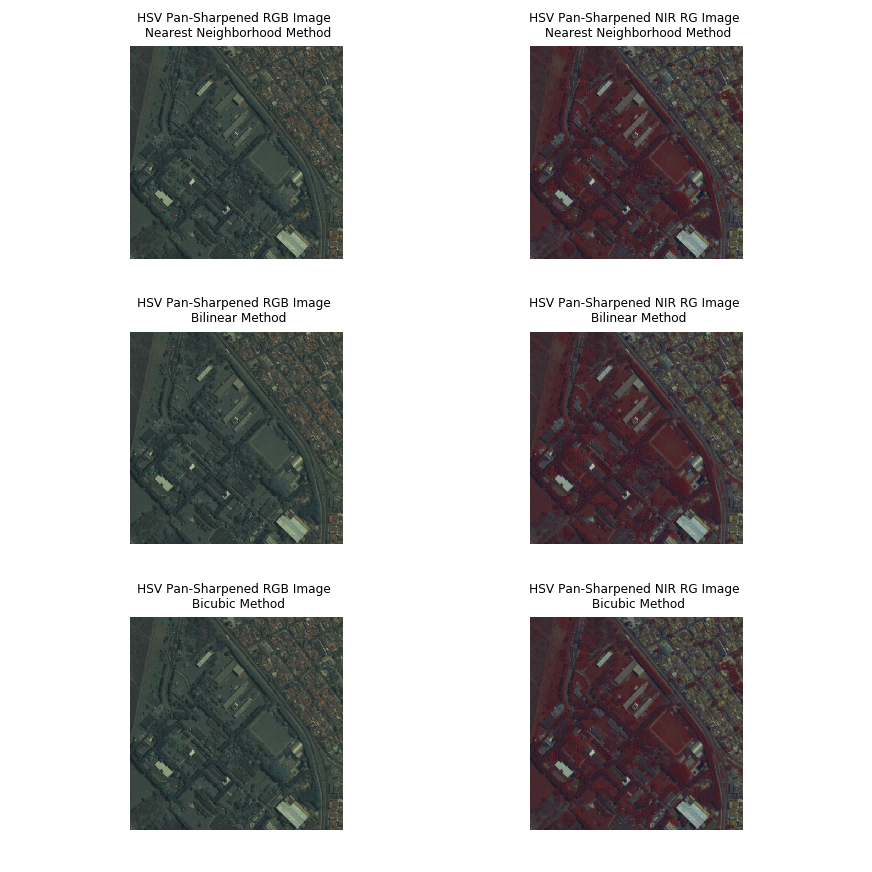

In [19]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_Pan_rgb_nn.astype('uint8'))
ax1.set_axis_off()
ax1.set_title('HSV Pan-Sharpened RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_Pan_rgb_bl.astype('uint8'))
ax3.set_axis_off()
ax3.set_title('HSV Pan-Sharpened RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_Pan_rgb_bc.astype('uint8'))
ax5.set_axis_off()
ax5.set_title('HSV Pan-Sharpened RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_Pan_nrg_nn.astype('uint8'))
ax2.set_axis_off()
ax2.set_title('HSV Pan-Sharpened NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_Pan_nrg_bl.astype('uint8'))
ax4.set_axis_off()
ax4.set_title('HSV Pan-Sharpened NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_Pan_nrg_bc.astype('uint8'))
ax6.set_axis_off()
ax6.set_title('HSV Pan-Sharpened NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()


if save_figs == True:
    plt.savefig('hsi_pansharp.png', dpi=dpi)

In the images above we can see clearly that pan sharpening yields a higher resolution image when compared with the raw bands. In the same time, by using multiple bands we can complement the panchromatic's resolution with color data coming from joining the other bands

### Adjusting the mean and std

In order to create the PCA pan-sharpening it's important to adjust the mean and standard deviation of the panchromatic band to that of the PC1 distribution. In this case we used the following method to adjust the distribution:

Consider a distribution $(x_i)$ with mean $m_1$ and standard deviation $s_1$ that we want to approximate to the mean and standard deviation of a second distribution, $m_2$ and $s_2$ respectively. The adjusted distribution can be calculated as:

$$y_i = m_2 + (x_i - m_i)*\frac{s_2}{s_1}$$

In [20]:
pc1, pan = pansharpening_PCA(img_rgb_resize_nn, img_raw_pan, report=True)

In [21]:
adjusted = adjust_dist(pan, pc1)

<IPython.core.display.Javascript object>


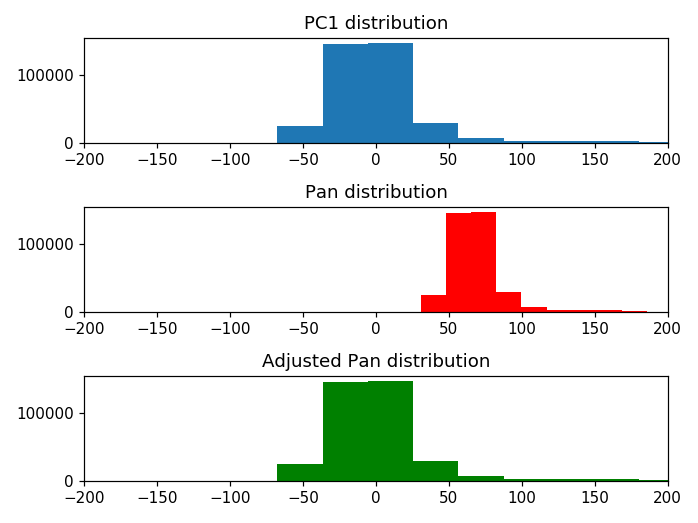

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.hist(pc1)
ax1.set_xlim(-200,200)
ax1.set_title('PC1 distribution')
ax2.hist(pan, color='r')
ax2.set_xlim(-200,200)
ax2.set_title('Pan distribution')
ax3.hist(adjusted, color='g')
ax3.set_xlim(-200,200)
ax3.set_title('Adjusted Pan distribution')

fig.tight_layout()


if save_figs == True:
    plt.savefig('distribution.png', dpi=dpi)

As we can see clearly in the graphs, the resulted adjusted pan distribution ressembles the original PC1 distribution. This method consists in translading the distribution to the targe one's mean and shrinking or expanding it to a similar standard deviation.

### The effect of mean and std adjustment in the final PCA Pan-Sharped image

The images below show that by not adjusting the distribution before substituting the PAN values, we result in a artificially bright image, which is not the cas in the adjusted image.

<IPython.core.display.Javascript object>


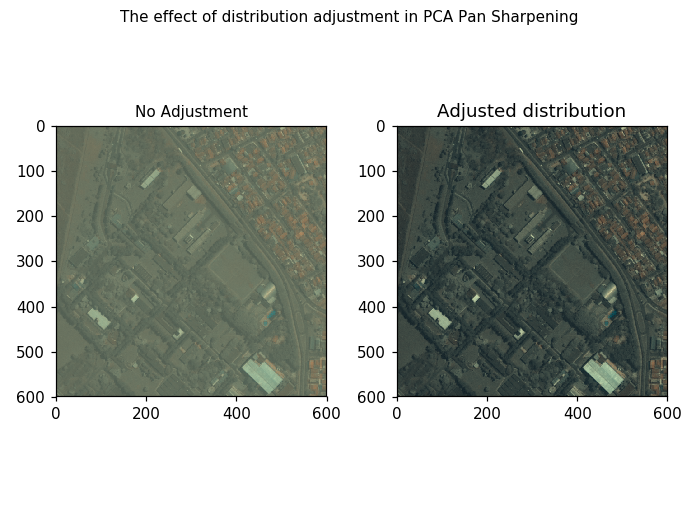

In [23]:
pan_noadjust = pansharpening_PCA(img_rgb_resize_nn,img_raw_pan, ms=False)
pan_adjust = pansharpening_PCA(img_rgb_resize_nn,img_raw_pan)

fig, axis = plt.subplots(1,2)
axis[0].imshow(pan_noadjust.astype('uint8'))
axis[0].set_title('No Adjustment', fontsize=10)
axis[1].imshow(pan_adjust.astype('uint8'))
axis[1].set_title('Adjusted distribution')
fig.suptitle('The effect of distribution adjustment in PCA Pan Sharpening', fontsize=10)
fig.tight_layout()

if save_figs == False:
    plt.savefig('adjust.png', dpi=dpi)

### PCA pan sharpening

We now use the PCA method to pan-sharp the images while adjusting the PAN's means and std to PC1 before making the substitution

In [24]:
img_PanPCA_rgb_nn = pansharpening_PCA(img_rgb_resize_nn,img_raw_pan)
img_PanPCA_rgb_bl = pansharpening_PCA(img_rgb_resize_bl,img_raw_pan)
img_PanPCA_rgb_bc = pansharpening_PCA(img_rgb_resize_bc,img_raw_pan)

In [25]:
img_PanPCA_nrg_nn = pansharpening_PCA(img_nrg_resize_nn,img_raw_pan)
img_PanPCA_nrg_bl = pansharpening_PCA(img_nrg_resize_bl,img_raw_pan)
img_PanPCA_nrg_bc = pansharpening_PCA(img_nrg_resize_bc,img_raw_pan)

<IPython.core.display.Javascript object>


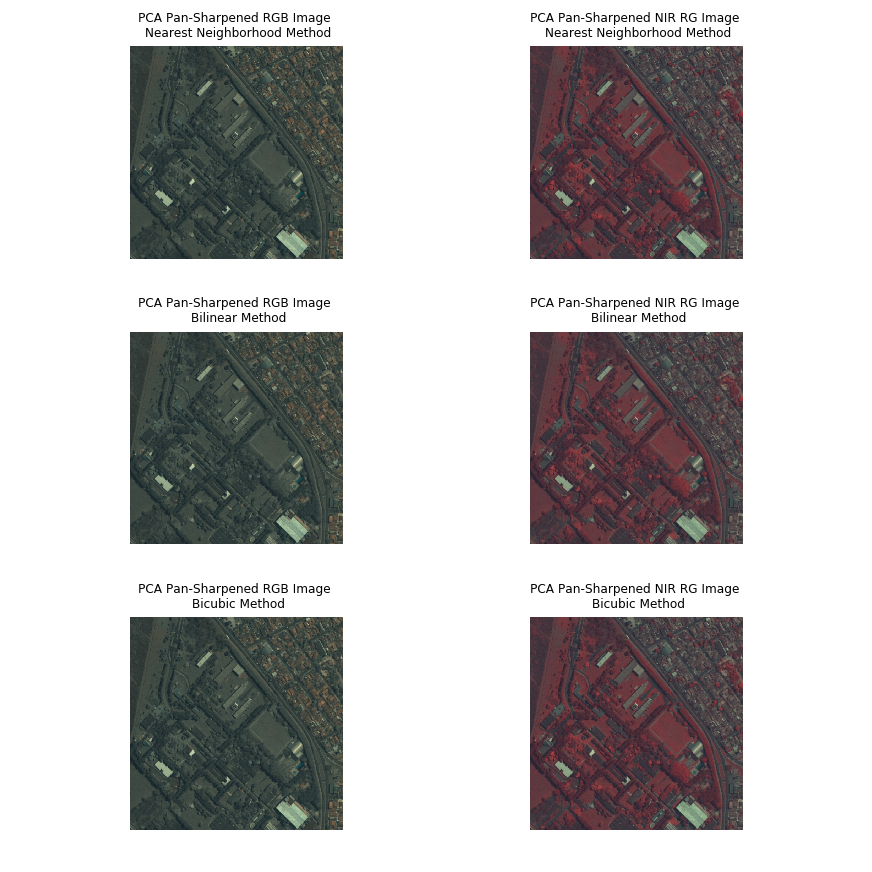

In [26]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_PanPCA_rgb_nn.astype('uint8'))
ax1.set_axis_off()
ax1.set_title('PCA Pan-Sharpened RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_PanPCA_rgb_bl.astype('uint8'))
ax3.set_axis_off()
ax3.set_title('PCA Pan-Sharpened RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_PanPCA_rgb_bc.astype('uint8'))
ax5.set_axis_off()
ax5.set_title('PCA Pan-Sharpened RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_PanPCA_nrg_nn.astype('uint8'))
ax2.set_axis_off()
ax2.set_title('PCA Pan-Sharpened NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_PanPCA_nrg_bl.astype('uint8'))
ax4.set_axis_off()
ax4.set_title('PCA Pan-Sharpened NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_PanPCA_nrg_bc.astype('uint8'))
ax6.set_axis_off()
ax6.set_title('PCA Pan-Sharpened NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()

if save_figs == True:
    plt.savefig('pca_pansharp.png', dpi=dpi)

### Comparing PCA to HSV pan sharpening

In the end we see that both PCA and HSV methods yield good results. By comparing the difference between both images, we can see that the difference in the outputs is really small for this image set

<IPython.core.display.Javascript object>


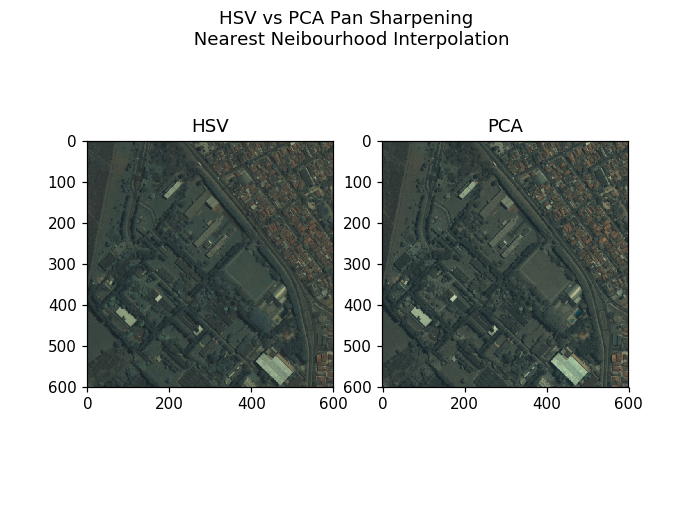

In [27]:
HSV_pan = pansharpening_HSV(img_rgb_resize_nn,img_raw_pan)
PCA_pan = pansharpening_PCA(img_rgb_resize_nn,img_raw_pan)

fig, axis = plt.subplots(1,2)
axis[0].imshow(HSV_pan)
axis[0].set_title('HSV')
axis[1].imshow(PCA_pan.astype('uint8'))
axis[1].set_title('PCA')
fig.suptitle('HSV vs PCA Pan Sharpening \n Nearest Neibourhood Interpolation')

if save_figs == True:
    plt.savefig('PCAvsHSV.png', dpi=dpi)

<IPython.core.display.Javascript object>


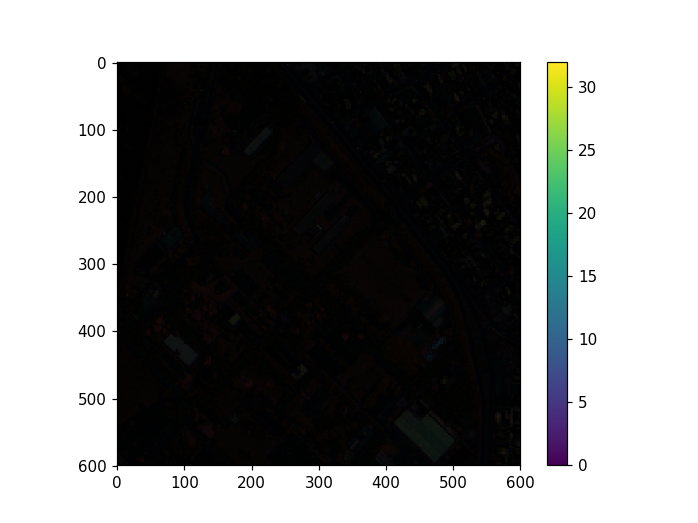

In [28]:
diff = abs(HSV_pan - PCA_pan)
plt.figure()
plt.imshow(diff.astype('uint8'))
plt.colorbar()
np.mean(diff), np.std(diff)

if save_figs == True:
    plt.savefig('PCAvsHSVdiff.png', dpi=dpi)

## Conclusion

In the end we were able to Pansharp the images by using both the HSV and PCA methods. Both methods seemed to yield similar results, while the bicubic interpolation seemed to be the best for resizing the initial lower resolution images. By comparing the NIR RG and the RGB images, we see clearly that the first one allow us to better distinguish the vegetation

## 2nd Problem - Georeferencing for area estimation over time

In [29]:
%%capture
cd Georeferencing/ 

### Introduction

The second problem was based on analysing the area change of the irregular settlement of Rio das Pedras from 1975 to 2010 by using aerial images in seven epochs: 1975, 1984, 1996, 2004, 2010.

![Rio das Pedras](http://rioonwatch.org.br/wp-content/uploads/2017/02/Rio-das-Pedras.-Foto-Custodio-Coimbra-O-Globo.jpg)

### Methodology

By starting with a georeferenced IKONOS image from 2010, we were able to co-register the other images by using the QGIS software. A reference image from the city hall was used to determine the limits of the settlement. From the co-registed images and the reference (also co-registered) limit map, the area was determined over time

In [30]:
# %%capture
# #This cell generates the full resolution images.

# year = ['1975', '1984', '1990', '1996', '2000','2004', '2010']

# for i in range(len(year)-1):
#     var = 'img_' + year[i]
#     vars()[var] = plt.imread('RIO_DAS_PEDRAS_'+year[i]+'.tif')

# fig,((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

# axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# data = [img_1975, img_1984, img_1990, img_1996, img_2000, img_2004]

# for i in range(6):

#     axes[i].imshow(data[i])
#     axes[i].set_axis_off()
#     axes[i].set_title(year[i])

# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


# if save_figs == True:
#     plt.savefig('rio_year.png', dpi=dpi)

![year](rio_year.png)

![Qgis3](https://qgisblog.files.wordpress.com/2018/02/splash30_v2.png)

### Reference map for determining the settlement's limits

(http://portalgeo-pcrj.opendata.arcgis.com/datasets/8454eb0454b7424d89c61b67742286a1_15)

![Area](area_rdp_prefeitura.png)

### Results

### Co-Registered Images

![georef](georef_1.png)

### 1975

![Area1975](area_1975_hec.png)

### 1984

![Area1984](area_1984_hc.png)

### 1990

![Area1990](area_1990_hec.png)

### 1996

![Area1996](area_1996_hc.png)

### 2000

![Area2000](area_2000_hc.png)

### 2004

![Area2004](area_2004_hc.png)

### 2010

![Area2010](area_2010_hc.png)

### Area change 1975-2010

In [31]:
data = {'Year':[1975,1984,1990,1996,2000,2004,2010], 'Area (hc)': [19.495, 18.352, 29.492, 47.479, 57.119,60.305, 60.053 ], 'Area Proportion': np.zeros(7)}

In [32]:
df = pd.DataFrame(data = data )
df['Area Proportion'] = df['Area (hc)']/df['Area (hc)'][0]
df

Area (hc)  Area Proportion  Year
0     19.495         1.000000  1975
1     18.352         0.941370  1984
2     29.492         1.512798  1990
3     47.479         2.435445  1996
4     57.119         2.929931  2000
5     60.305         3.093357  2004
6     60.053         3.080431  2010

<IPython.core.display.Javascript object>


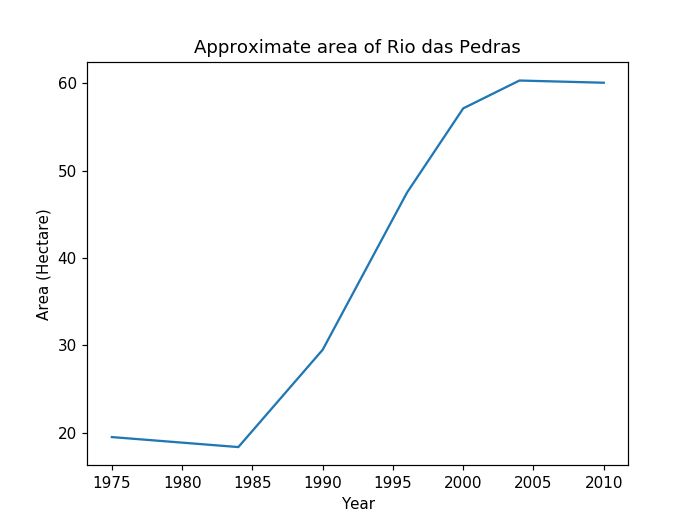

In [33]:
plt.figure()
plt.plot(df['Year'], df['Area (hc)'])
plt.xlabel('Year')
plt.ylabel('Area (Hectare)')
plt.title('Approximate area of Rio das Pedras')
plt.show()
if save_figs == True:
    plt.savefig('AreaxYear.png', dpi=dpi)

### Conclusion

We can see that the Rio das Pedras' area increase from aroung 20 hectars to 60 hectars. The biggest spread happened between 1985 and 2000, since then it seems to have slowed down